# SOHO MDI and Sunspotter Scores

## Data Exploration 

### Dataset in a Nutshell

- Image data collected by SOHO/MDI
- MDI instrument data / SMART cutouts
- Citizen science project to label (some of) the data (around 60,000 images?): People asked to classify which of two images is more complex
- Complexity score computed from resulting rankings
- Dataset consists of 
    - metadata file (incl. score and image file name)
    - image files


### Download Data

Can be downloaded from XXX <br>


In [12]:
!mkdir -p ./data/MDIComplexityScores
!curl -Ss 'https://dl.dropboxusercontent.com/s/le0isfa0r5c0w8z/sunspot_data.zip' | tar -xf - -C ./data/MDIComplexityScores

Install dependencies, make sure to first follow the setup instructions in the [README](../README.md), when running this locally:

In [2]:
!pip install -U tqdm
!pip install -U torch torchvision
!pip install -U numpy
!pip install -U matplotlib 
!pip install -U Pillow
!pip install -U pandas

In [13]:
# Data location
DATADIR = "./data/MDIComplexityScores/data/images/"
METADATA_FILE = "./data/MDIComplexityScores/data/image_metadata.csv"

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

### Load Data Metadata

In [16]:
metadata = pd.read_csv(METADATA_FILE)
metadata.tail()

,Unnamed: 0,#id_x,filename_x,zooniverse_id,angle,area,areafrac,areathesh,bipolesep,c1flr24hr,...,zurich,#id_y,image_id,count,k_value,score,std_dev,#id,filename_y,obs_date
12960,12960,609,530be11e3ae74079c30004cd.jpg,ASZ00000kt,20.8618,126000.0,0.01,16200.0,7.19,1,...,fkc,12961,609,50,8,1478.125224,1.720382,609,20000313_1251_mdiB_2_8906.fits,2000-03-13 12:51:02
12961,12961,3840,530be13e3ae74079c3001e0b.jpg,ASZ00007r7,28.6813,128000.0,-0.02,18300.0,1.22,1,...,fki,12962,3840,50,8,1482.411731,2.839833,3840,20010330_1248_mdiB_2_9393.fits,2001-03-30 12:48:02
12962,12962,7824,530be1663ae74079c3003d2b.jpg,ASZ00004po,21.8158,155000.0,-0.01,22200.0,3.73,1,...,fkc,12963,7824,50,8,1483.847566,1.842268,7824,20020727_1247_mdiB_2_0039.fits,2002-07-27 12:47:00
12963,12963,1224,530be1243ae74079c300099b.jpg,ASZ000093u,51.4482,211000.0,0.06,20800.0,3.16,1,...,ekc,12964,1224,50,8,1487.488269,2.072438,1224,20000522_1251_mdiB_3_8996.fits,2000-05-22 12:51:03
12964,12964,5587,530be14f3ae74079c3002bb1.jpg,ASZ00006ei,56.0346,175000.0,0.05,22300.0,1.22,1,...,dki,12965,5587,50,8,1488.084217,2.509496,5587,20011027_1247_mdiB_2_9672.fits,2001-10-27 12:47:02


Here we are only interested in the `score` variable.

In [17]:
score = metadata.score
score

0         950.403592
1         953.549821
2         954.324334
3         955.205675
4         956.152484
            ...     
12960    1478.125224
12961    1482.411731
12962    1483.847566
12963    1487.488269
12964    1488.084217
Name: score, Length: 12965, dtype: float64

### First Glance at a Sample Image

(360, 289) RGB
(289, 360, 3)
0 255


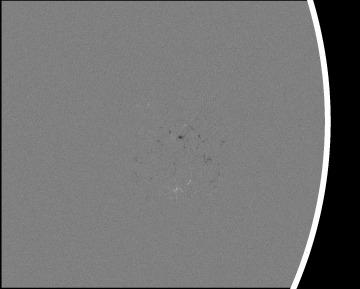

In [18]:
samplefile = metadata.filename_x[0]
image = Image.open(DATADIR + samplefile)
imgarray = np.asarray(image)

print(image.size, image.mode)
print(imgarray.shape)
print(imgarray.min(), imgarray.max())
image

### Load and preprocess the images

- Load image, possibly resize with a suitable ratio.
- Average over color channels.
- Rescale intensity scale to be between `[0,1]`
- Rearrange to have the channels in the first dimension

Data are stored in the format (image_no, x_pixel, y_pixel)

In [19]:
def preprocess_data( image_path, ratio=1 ):

    # create empty data cube
    data = []

    for file in tqdm( metadata.filename_x ):

        # Load and resize image
        image = Image.open(image_path + file)
        new_size = (np.array( image.size ) / ratio).astype( int )
        image = image.resize( new_size )

        # compute the mean along the color channel
        image = np.mean( image, axis=2 )

        # append the image to data list
        data.append( image )
    
    # stack elements of the list into a data cube
    data = np.dstack( data )
    
    # permute dimensions to better format 
    data = np.transpose( data, axes=(2,0,1) )
    
    # make sure pixel values are between 0 and 1
    data = data / 255
    
    return data

In [20]:
data = preprocess_data( DATADIR, ratio=4 )
print( "Data shape: {}".format( data.shape ) )

100%|████████████████████████████████████████████████████████████████████| 12965/12965 [00:25<00:00, 504.92it/s]


Data shape: (12965, 72, 90)


### Plot Many Examples

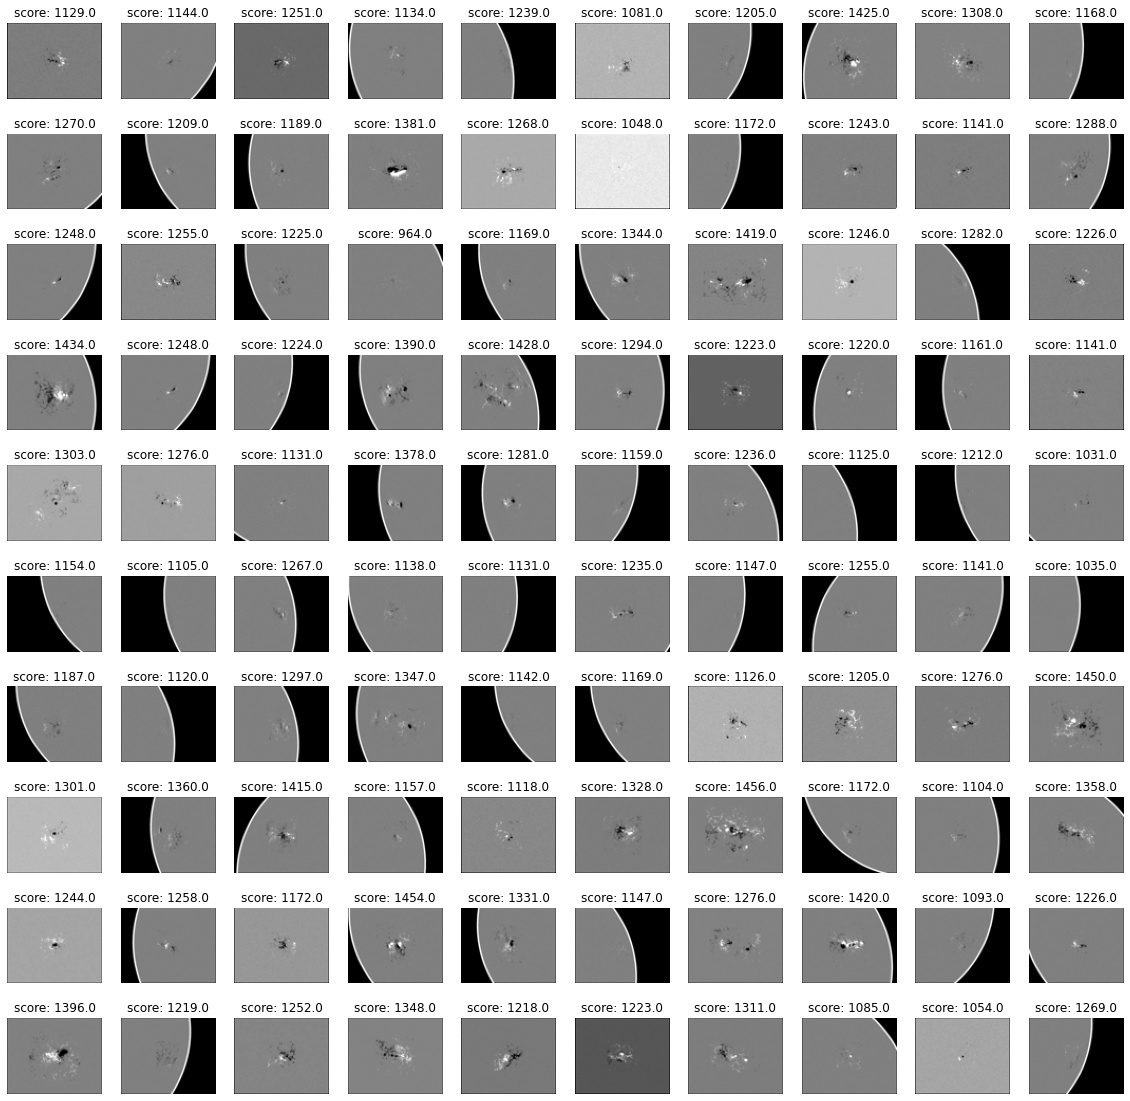

In [21]:
plt.figure( figsize=(20,20) )
n = 10
m = 10
for i in range(n):
    for j in range(m):
        plt.subplot( n, m, n*i+j+1 )
        image = np.random.randint( data.shape[0] )
        plt.title( "score: {}".format( np.round( metadata.score[image]) ) )
        plt.imshow( data[image,:,:], cmap="gray" )
        plt.axis('off')

### Complexity score distribution

(array([ 258.,  728., 1310., 1955., 2317., 2121., 1750., 1326.,  858.,
         342.]),
 array([ 950.40359155, 1004.17165407, 1057.93971658, 1111.7077791 ,
        1165.47584161, 1219.24390413, 1273.01196664, 1326.78002916,
        1380.54809167, 1434.31615419, 1488.0842167 ]),
 <BarContainer object of 10 artists>)

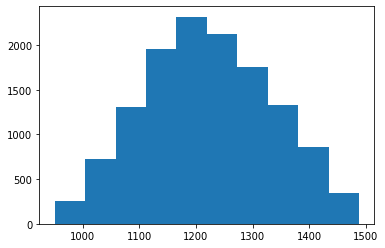

In [22]:
plt.hist( score )

# TODO refactor this to use Pytorch

### Split into training and test set

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, score, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10372, 72, 90), (2593, 72, 90), (10372,), (2593,))

## Modeling the Data

To Be Continued

In [8]:
X_train_dense = X_train.reshape( X_train.shape[0], -1 )    
X_test_dense = X_test.reshape( X_test.shape[0], -1 )
X_train_dense.shape, X_test_dense.shape

((10372, 6480), (2593, 6480))

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define the model
model = Sequential([
  Dense(500, activation='relu', input_shape=(X_train_dense.shape[1],)),
  Dense(300, activation='relu'),
  Dense(1, activation='linear'),
])

# compile the model
model.compile(
  optimizer='adam',
  loss='mse'
)

# train the model
log = model.fit(
  X_train_dense,
  y_train, 
  epochs=5,
  batch_size=32,
  validation_data=(X_test_dense, y_test)
)

Epoch 1/5
325/325 [==============================] - 4s 12ms/step - loss: 70860.2188 - val_loss: 12348.8643
Epoch 2/5
325/325 [==============================] - 4s 12ms/step - loss: 12332.6963 - val_loss: 12113.2451
Epoch 3/5
325/325 [==============================] - 4s 12ms/step - loss: 12363.4219 - val_loss: 12338.8730
Epoch 4/5
325/325 [==============================] - 5s 15ms/step - loss: 12063.3594 - val_loss: 12658.4570
Epoch 5/5
325/325 [==============================] - 5s 14ms/step - loss: 12169.4277 - val_loss: 12771.6406


Learning curve:

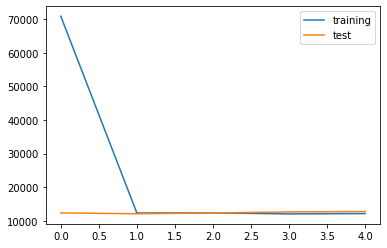

In [10]:
plt.plot( log.history['loss'], label='training' )
plt.plot( log.history['val_loss'], label='test' )
plt.legend()

Predictions:

In [11]:
y_test_pred = model.predict( X_test_dense )

Text(0, 0.5, 'true')

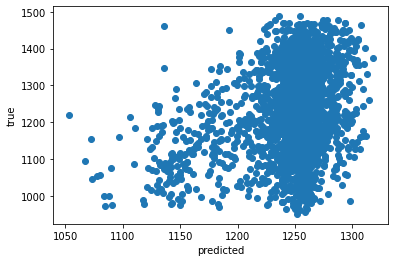

In [12]:
plt.scatter( y_test_pred, y_test )
plt.xlabel("predicted")
plt.ylabel("true")

In [13]:
from sklearn.metrics import r2_score, mean_squared_error
rmse = np.sqrt( mean_squared_error( y_test, y_test_pred ) )
r2 = r2_score( y_test, y_test_pred )
print("RMSE = {}, R2 = {}".format( rmse, r2 ) )

RMSE = 113.0116852094267, R2 = 0.007703853465279131


## CNN

In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

# define the model
model = Sequential([
    Conv2D( filters=16, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(data.shape[1],data.shape[2],1)),
    Conv2D( filters=16, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Conv2D( filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D( filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
    Flatten(),
    Dense( 1000 ),
    Dense( 800 ),
    Dense( 500 ),
    Dense( 100 ),
    Dense(1, activation='linear')
])

# compile the model
model.compile(
  optimizer='adam',
  loss='mse'
)

print( model.summary() )


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 72, 90, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 45, 16)        2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 45, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 23, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 13248)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              13249000  
_________________________________________________________________
dense_4 (Dense)              (None, 800)              

In [15]:
X_train_cnn = np.expand_dims( X_train, axis=-1 )
X_test_cnn = np.expand_dims( X_test, axis=-1 )

In [16]:
log = model.fit(
  X_train_cnn,
  y_train, 
  epochs=5,
  batch_size=32,
  validation_data=(X_test_cnn, y_test)
)

Epoch 1/5
325/325 [==============================] - 48s 148ms/step - loss: 40735.1641 - val_loss: 11958.5850
Epoch 2/5
325/325 [==============================] - 47s 145ms/step - loss: 7487.9683 - val_loss: 4026.9136
Epoch 3/5
325/325 [==============================] - 51s 158ms/step - loss: 5113.6704 - val_loss: 11541.2148
Epoch 4/5
325/325 [==============================] - 52s 161ms/step - loss: 4483.6670 - val_loss: 3303.1609
Epoch 5/5
325/325 [==============================] - 47s 144ms/step - loss: 5273.0103 - val_loss: 9300.4141


Learning curve:

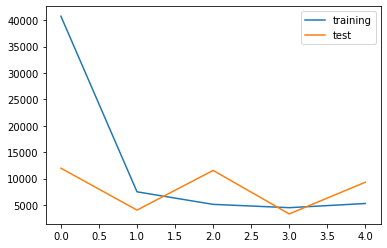

In [17]:
plt.plot( log.history['loss'], label='training' )
plt.plot( log.history['val_loss'], label='test' )
plt.legend()

Predictions:

In [18]:
y_test_pred = model.predict( X_test_cnn )

Text(0, 0.5, 'true')

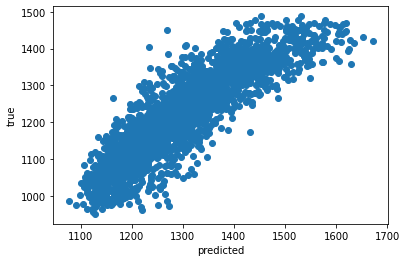

In [19]:
plt.scatter( y_test_pred, y_test )
plt.xlabel("predicted")
plt.ylabel("true")

In [20]:
from sklearn.metrics import r2_score, mean_squared_error
rmse = np.sqrt( mean_squared_error( y_test, y_test_pred ) )
r2 = r2_score( y_test, y_test_pred )
print("RMSE = {}, R2 = {}".format( rmse, r2 ) )

RMSE = 96.43865304276233, R2 = 0.2774018013784245
